# Analiza i preprocesiranje podataka

NAPOMENA: neka filtriranja, treniranje i sl. se mogu dugo izvrsavati (od nekoliko sekundi, do nekoliko minuta).

In [1]:
import numpy as np
import pandas as pd

In [2]:
from matplotlib import pyplot as plt

In [3]:
import nltk
from string import punctuation

In [4]:
import pickle

In [5]:
import os

In [6]:
from sklearn import datasets
from sklearn import preprocessing

In [7]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vkova\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vkova\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

***newsgroup*** - kao neke prepiske na forumima na datu temu

1. Pripremamo podatke.
2. Obucavamo 2 modela za klasifikaciju - SVM i CNN za klasifikaciju tekstova u jednu od 20 klasa.
3. Odredjujemo u kojoj meri su reci teksta zasluzne za izlaz klasifikatora - odredicemo relevantnost reci.

In [8]:
# ucitavamo skupove za test i trening
# uklanjamo samo header-e (korisno u preprocesiranju - dosta nebitnih informacija u header-ima)

train_data = datasets.fetch_20newsgroups(random_state=61, remove=('headers'))
test_data = datasets.fetch_20newsgroups(random_state=61, subset='test', remove=('headers'))

In [9]:
# detaljan opis "20ng" skupa podataka

#print(train_data.DESCR)

In [10]:
X_train = train_data.data
y_train = train_data.target
X_test = test_data.data
y_test = test_data.target
feature_names = train_data.target_names
num_of_features = len(feature_names)

In [11]:
# upoznajemo se bolje sa nasim skupom podataka

#print(type(X_train))
#print(len(X_train))
#print(feature_names)

In [12]:
# primer jedne istance (clanka), uz odgovarajucu klasu kojoj pripada

#print(X_train[0])
#print(y_train[0])
#print(feature_names[y_train[0]])

In [13]:
# broj instanci skupova za treniranje i testiranje

N_train = len(X_train)
N_test = len(X_test)

print("train: ", N_train)
print("test: ", N_test)

train:  11314
test:  7532


In [14]:
# ispitujemo balansiranost skupa za trening i test

y_train = np.array(y_train)
instances_per_class_train = [len(y_train[y_train == i]) for i in range(num_of_features)]

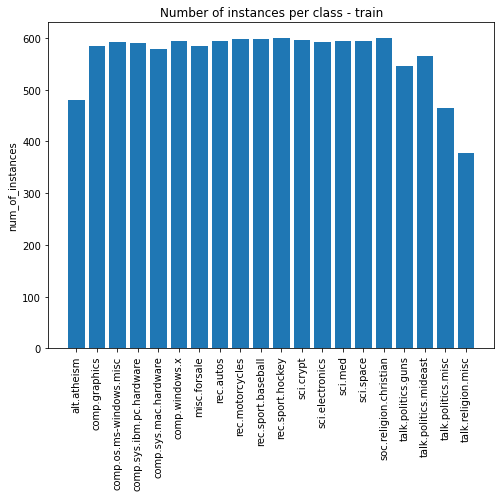

In [15]:
plt.figure(figsize=(8,6))

plt.title("Number of instances per class - train")

plt.xticks(range(num_of_features), labels=feature_names, rotation='vertical')
plt.ylabel(ylabel="num_of_instances")
plt.bar(range(num_of_features), instances_per_class_train)

plt.show()


In [16]:
# ispitujemo balansiranost skupa za trening i test

y_test = np.array(y_test)
instances_per_class_test = [len(y_test[y_test == i]) for i in range(num_of_features)]

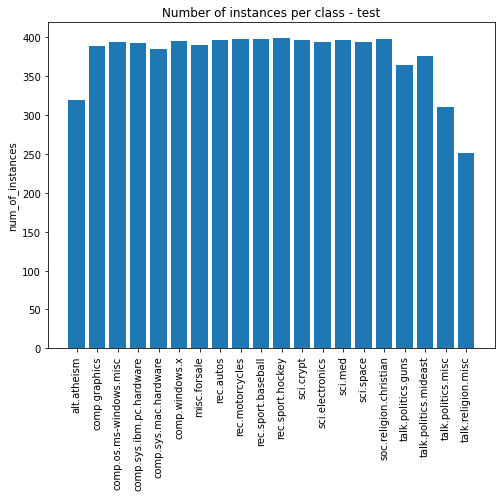

In [17]:
plt.figure(figsize=(8,6))

plt.title("Number of instances per class - test")

plt.xticks(range(num_of_features), labels=feature_names, rotation='vertical')
plt.ylabel(ylabel="num_of_instances")
plt.bar(range(num_of_features), instances_per_class_test)

plt.show()


In [18]:
# zakljucujemo da radimo sa balansiranim skupovima podataka.

# dalje analizaramo nas trening skup

# izvrsimo tokenizaciju kako bi lakse analizirali tekstove po recima

In [19]:
def stats(about, X):
    print(f"{about} mean: ", f"{X.mean():.2f}")
    print(f"{about} std: ", f"{X.std():.2f}")
    print(f"{about} max: ", X.max())
    print(f"{about} min: ", X.min())

In [20]:
X_train_tok = [nltk.tokenize.word_tokenize(text) for text in X_train]

In [21]:
# recnik (sve razlicite reci)

In [22]:
vocab = {word for text in X_train_tok for word in text}

In [23]:
# broj reci po tekstu

text_lens = np.array([len(text) for text in X_train_tok])

In [24]:
stats("Number of word", text_lens)
print("Number of words total: ", text_lens.sum())
print("Number of distinct words: ", len(vocab))
# kasnije cemo odsecati (i filtrirati)

Number of word mean:  388.52
Number of word std:  1342.51
Number of word max:  35955
Number of word min:  0
Number of words total:  4395725
Number of distinct words:  195313


In [25]:
# broj reci koje pocinju velikim slovom (po tekstu)

In [26]:
upper_case = np.array([len([word for word in text if word.isupper()]) for text in X_train_tok])

In [27]:
stats("Upper case per text", upper_case)

Upper case per text mean:  32.14
Upper case per text std:  448.99
Upper case per text max:  13853
Upper case per text min:  0


In [28]:
# broj reci koje pocinju brojem (po tekstu)

In [29]:
from string import digits

In [30]:
startswith_num = lambda x : True in [x.startswith(num) for num in list(digits)]

In [31]:
numstart = np.array([len([word for word in text if startswith_num(word)]) for text in X_train_tok])

In [32]:
stats("Starts with num per text", numstart)

Starts with num per text mean:  11.92
Starts with num per text std:  104.25
Starts with num per text max:  5169
Starts with num per text min:  0


In [33]:
# broj stop reci (stopwords) (po tekstu)

In [34]:
stopwords = nltk.corpus.stopwords.words('english')

In [35]:
stopwords_num = np.array([len([word for word in text if word in stopwords]) for text in X_train_tok])

In [36]:
stats("Stopwords per text", stopwords_num)

Stopwords per text mean:  97.25
Stopwords per text std:  202.22
Stopwords per text max:  5343
Stopwords per text min:  0


In [37]:
print(f"Stopwords in corpus: {100*(stopwords_num.sum()/text_lens.sum()):.2f}%")

Stopwords in corpus: 25.03%


In [38]:
# primecujemo da stop reci (ocekivano) predstavljaju znacajan deo naseg korpusa, treba doneti odluku da li da se uklone ili ne
# obicno se uklanjaju, medjutim, zbog LRP moramo razmisliti

In [39]:
# broj znakova . , ! # ? i sl. (znakova iz string.punctuation) (po tekstu)

In [40]:
from string import punctuation

In [41]:
punct_num = np.array([len([word for word in text if word in list(punctuation)]) for text in X_train_tok])

In [42]:
stats("Punctuations per text", punct_num)

Punctuations per text mean:  90.60
Punctuations per text std:  647.97
Punctuations per text max:  22145
Punctuations per text min:  0


In [43]:
# broj reci koje pocinju malim slovom (po tekstu)

In [44]:
lower_words = {word for word in vocab if word.islower()}

In [45]:
print(len(lower_words))

67149


In [46]:
# broj reci koje pocinju velikim slovom, a jednake su nekoj reci koje pocinju malim slovom
# npr. Tonight = tonight = TONIGHT

# zasto je ovo bitno? 
# kad kasnije budemo filtrirali, mozda cemo preci na lowercase
# time gubimo informacije npr. RAM (memorija) != ram (ovca, oruzje za opsadu, glagol, ...)
# a posle lowercasing-a ce postati...

In [47]:
lower_and_upper = [word for text in X_train_tok for word in text if word.isupper() and word.lower() in lower_words]

In [48]:
print("Lower-upper words in corpus: ", len(lower_and_upper))
print(f"Lower-upper words in corpus: {100*len(lower_and_upper)/text_lens.sum():.2f}%")

Lower-upper words in corpus:  174071
Lower-upper words in corpus: 3.96%


In [49]:
# dalje mozemo jos razne zanimljivosti izvlaciti...

## Tokenizacija i filtriranje

1. Tokenizujemo tekstove (koristicemo *nltk* biblioteku -  vec obavljeno).
2. Zadrzimo samo reci koje sadrze slova, tacku, apostrof, i crticu (i bar jedno slovo - ne zelimo samo **.** npr.).
3. Pripremimo vektorizator koji ce dodatno prebaciti sve reci u mala slova i izbaciti one koje se javljaju u manje od 2 dokumenta (pretpostavljamo da su to pogresno napisane reci).
4. Iako nije navedeno, mozemo izbaciti i poznate stop-reci (*stopwords*) - ovo ce nam takodje vektorizator omoguciti.

### 1. Tokenizacija

In [50]:
# obavljena

### 2. Filtriranje

In [51]:
from string import ascii_letters

In [52]:
retain_chars = list(ascii_letters) + list(".-'")

In [54]:
def retain_word(word):
    # sastoji se samo od slova . -  '
    for c in list(word):
        if c not in retain_chars:
            return False
    
    # sadrzi bar jedno slovo
    for c in list(word):
        if c.isalpha():
            return True
        
    return False

In [55]:
def filter_text(text):
    text = [word for word in text if retain_word(word)]
    return text

In [56]:
X_train_tok_filt = [filter_text(text) for text in X_train_tok] 

### 3. Vektorizator

In [57]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [58]:
# pripremamo vektorizator 
#    - min_df=2 izbacuje reci koje se pojavljuju samo u jednom tekstu
#    - tokenizator koji smo koristili (moramo vratiti recenice u sirov oblik)
#    - NECEMO raditi lowercasing
#    - napravicemo jos jedan vektorizator koji izbacuje stop reci (eksperimentalno)

In [59]:
vectorizer = TfidfVectorizer(min_df=2, tokenizer=nltk.tokenize.word_tokenize, lowercase=False)

In [60]:
# ako zelimo da izbacimo stop-reci

#filter_words = stopwords + list(punctuation)
#vectorizer_filterstop = TfidfVectorizer(min_df=2, tokenizer=nltk.tokenize.word_tokenize, stop_words=filter_words)

In [61]:
# fit-ujemo vektorizator - samo na trening skupu (da informacije ne procure)

In [62]:
X_train_filtered = [" ".join(text) for text in X_train_tok_filt]

In [63]:
%%time
vectorizer.fit(X_train_filtered)

C:\Users\vkova\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


CPU times: total: 6.45 s
Wall time: 6.47 s


TfidfVectorizer(lowercase=False, min_df=2,
                tokenizer=<function word_tokenize at 0x00000219423ABD00>)

In [64]:
#vectorizer_filterstop.fit(X_train_filtered)

In [65]:
# reci koje je vektorizator "ostavio" nalaze se u njegovom vokabularu
# nadalje cemo pomocu njega filtrirati tekstove
# pogledajmo opet statistike duzine tekstova - za tekstove sa i bez stop reci

In [66]:
print("Vocab len: ", len(vectorizer.vocabulary_))

Vocab len:  55505


In [67]:
# filtrirajmo opet nas korpus
# izbacujemo reci koje nisu u vokabularu

# NAPOMENA: na ovaj nacin mozemo ubuduce filtrirati korpus (tokenizator nltk)
# sacuvajmo zato vectorizer

In [69]:
with open(os.path.join("models", "vectorizer.pickle"), "wb") as dump_file:
    pickle.dump(vectorizer, dump_file)

In [78]:
vocabulary = vectorizer.vocabulary_

In [79]:
X_train_final = [[word for word in text if word in vocabulary] for text in X_train_tok_filt ]

In [80]:
# ispitajmo sada kolike su duzine tekstova

In [81]:
text_lens_final = np.array([len(text) for text in X_train_final])

In [83]:
stats("Text lengths after preprocessing", text_lens_final)
print("Number of words total: ", text_lens_final.sum())
print("Number of distinct words: ", len(vocabulary))

Text lengths after preprocessing mean:  254.23
Text lengths after preprocessing std:  570.90
Text lengths after preprocessing max:  12783
Text lengths after preprocessing min:  0
Number of words total:  2876341
Number of distinct words:  55505


In [90]:
# koliko smo reci (tokena) izgubili kroz ovaj proces:

print("Words dropped: ", len(vocab) - len(vocabulary))
print(f"Words dropped %: {100*(len(vocab) - len(vocabulary))/len(vocab):.2f}%")
print("Total words dropped: ", text_lens.sum()-text_lens_final.sum())
print(f"Total words dropped %: {100*(text_lens.sum()-text_lens_final.sum())/text_lens.sum():.2f}%")

Words dropped:  139808
Words dropped %: 71.58%
Total words dropped:  1519384
Total words dropped %: 34.57%


In [91]:
more_than_400 = len(text_lens_final[text_lens_final>400])

In [92]:
print("Texts with more than 400 words: ", more_than_400)
print(f"Percentage: {100*more_than_400/N_train:.2f}%")

Texts with more than 400 words:  1381
Percentage: 12.21%


In [93]:
# broj tekstova po duzini

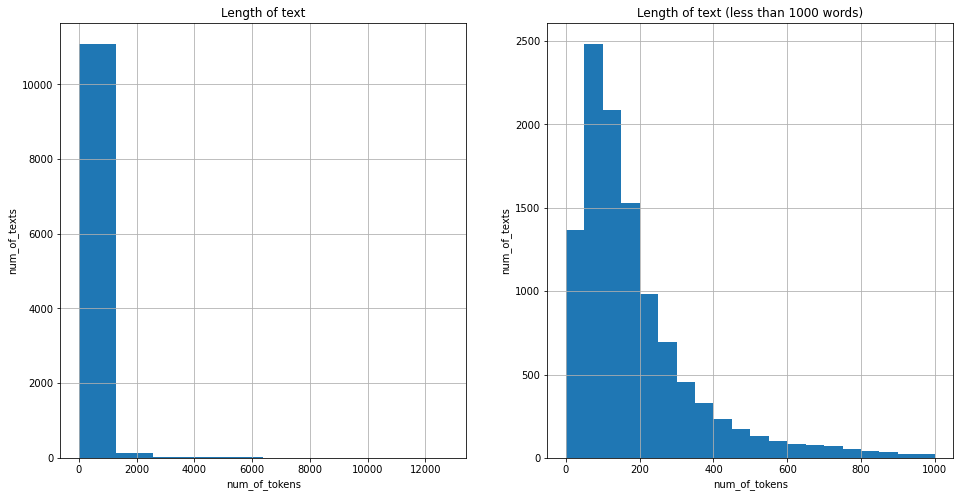

In [94]:
plt.figure(figsize=(16,8))

plt.subplot(121)
plt.title("Length of text")
plt.xlabel(xlabel="num_of_tokens")
plt.ylabel(ylabel='num_of_texts')
plt.hist(text_lens_final)
plt.grid(True)

plt.subplot(122)
plt.title("Length of text (less than 1000 words)")
plt.xlabel(xlabel="num_of_tokens")
plt.ylabel(ylabel='num_of_texts')
plt.hist(text_lens_final, range=(0,1000), bins=20)
plt.grid(True)

plt.show()

In [284]:
# zavrsili smo osnovnu analizu i preprocesiranje

# CBOW (word2vec embedding)

***word2vec*** je skup modela za **vektorizaciju reci** (***word embedding***). <br>
Ovi modeli recima dodeljuju **vektor** na osnovu njihovog ***'konteksta'*** ***(veze sa drugim recima)***.

U zavisnosti od toga **kako zelimo da modelujemo kontekst** reci, biramo jedan od 2 poznata modela:
1. ***CBOW (Continuous Bag of Words)*** - brzi i bolji za veci skup reci, kada su reci frekventnije
2. ***Skip-gram*** - bolje radi za manji skup reci, uspesno modeluje veze reci sa malom frekvencijom

*CBOW* na osnovu fiksiranog broja *(NAPOMENA: eksperimentise se i sa promenljivom velicinom - gensim dokumentacija)*  reci
oko ciljne reci pokusava da modeluje znacenje ciljne reci (reci u sredini). <br>
Za atribut se uzme npr. **prosek** okolnih reci.

In [95]:
# primer: "The cat sat on the mat"
# neka je window_size=2 (okolina ciljne reci)
# neka je ciljna rec "sat"
# --->
# mean(["The", "cat", "on", "the"]) - atribut
# "sat" - ciljna rec

*Skip-gram* radi slicno, uzima okolinu ciljne reci i iz nje izdvaja par (ciljna_rec, rec_iz_okoline).

In [96]:
# iz prethodnog primera:
# --->
# parovi (atribut,ciljna_rec): ("The", "sat"), ("cat", "sat"), ("on", "sat"), ("the", "sat")

Mi cemo koristiti *CBOW* model.

Iako su ovo modeli **nenadgledanog ucenja** (nemamo ciljnu promenljivu u skupu reci), mi ih obucavamo kao modele **nadgledanog ucenja** - izdvojimo neke kombinacije ***atribut - ciljna_promenljiva*** iz skupa reci (kao ranije sto smo opisali). <br>

Dalje se model trenira kao neuronska mreza. Primer jedne arhitekture:

In [97]:
#Model: "sequential"
#_________________________________________________________________
# Layer (type)                Output Shape              Param #   
#=================================================================
# embedding (Embedding)       (None, 4, 300)            3000000   
#                                                                 
# lambda (Lambda)             (None, 300)               0         
#                                                                 
# flatten (Flatten)           (None, 300)               0         
#                                                                 
# dense (Dense)               (None, 10000)             3010000   
                                                                 
#=================================================================
#Total params: 6,010,000
#Trainable params: 6,010,000
#on-trainable params: 0y

Koristicemo vec postojeci ***word2vec*** model biblioteke ***gensim***.

In [98]:
import gensim

In [99]:
# pravimo jedan w2v model:
# - vector_size -> velicina vektora koji dobijemo
# - min_count=0 -> ne zelimo dalje filtriranje po frekvenciji reci
# - sg=0        -> ne zelimo skip-grap, vec cbow model
# - hs=0        -> zelimo negative sampling
# - cbow_mean=1 -> zelimo sredinu okolnih reci

In [101]:
%%time
# ovo moze dugo potrajati (smanjiti broj epoha - inicijalno 20)

w2v_model = gensim.models.word2vec.Word2Vec(X_train_final,
                                           vector_size=300,
                                           min_count=0,
                                           sg=0,
                                           hs=0,
                                           negative=10,
                                           ns_exponent=0.75,
                                           cbow_mean=1,
                                           epochs=20,
                                            compute_loss=True
                                           )

CPU times: total: 3min 3s
Wall time: 1min 2s


In [102]:
# sacuvajmo ovaj model
w2v_model.save(os.path.join("models", "cbow.wv"))

In [306]:
# model mozemo ponovo da ucitamo

# gensim.models.word2vec.Word2Vec().load()
# ili
# gensim.models.word2vec.KeyedVectors().load()

In [103]:
cbow = w2v_model.wv

***Slicnost*** dveju reci se definise kao kosinus ugla koji njihovi vektori zaklapaju (***cosine similarity***).

In [104]:
def cosine_similarity(w1, w2):
    norm_w1 = np.linalg.norm(w1)
    norm_w2 = np.linalg.norm(w2)
    
    return np.dot(w1, w2)/(norm_w1*norm_w2)

In [350]:
# pogledajmo slicnosti nekih reci

In [105]:
print(cbow.similarity("motorcycle", "bike"))

print(cbow.similarity("supreme", "minor"))

print(cbow.similarity("modern", "horse"))

0.5860116
-0.1066406
-0.01931891


In [351]:
# pogledajmo najslicnije reci datim recima

In [106]:
words = ["king", "convolution", "neuron", "sun", "abstract"]

In [107]:
for word in words:
    similar = cbow.similar_by_key(word, topn=5)
    print("word: ", word)
    for sim_word in similar:
        print(sim_word[0], sim_word[1])
    print("---------------")

word:  king
Solomon 0.5540077090263367
Herod 0.5271088480949402
Isaac 0.5002740621566772
King 0.49667027592658997
Constantinople 0.4850626289844513
---------------
word:  convolution
Fourier 0.8425139784812927
transforms 0.8080564737319946
user-defined 0.7925676107406616
canned 0.7830947637557983
semilog 0.768878698348999
---------------
word:  neuron
humidity 0.5850765109062195
MUHAMMED 0.5682938694953918
gleaned 0.5652386546134949
MIFF 0.561920702457428
obtaining 0.5593813061714172
---------------
word:  sun
sky 0.4931747019290924
Jupiter 0.4763827621936798
comet 0.4712870419025421
moon 0.46211889386177063
orbit 0.4572937786579132
---------------
word:  abstract
introduction 0.5229272842407227
introductory 0.5037308931350708
overview 0.4965915083885193
asteroid 0.4890320599079132
manifests 0.45610108971595764
---------------


In [108]:
# ispitajmo slicnost nekih reci

words2 = ["boat", "sail", "of", "one", "the", "white", "monument", "star", "we", "peculiar", "juicy"]

In [109]:
def heatmap_similarities(words):
    similarities = []
    
    words = [word if word in cbow.key_to_index else "." for word in words]
    
    for word1 in words:
        similarities.append([cbow.similarity(word1, word2) for word2 in words])
        
    plt.figure(figsize=(8,8))


    plt.imshow(similarities, cmap='hot')
    plt.colorbar()

    plt.xticks(range(len(words)), words, rotation=90)
    plt.yticks(range(len(words)), words)

    plt.show()

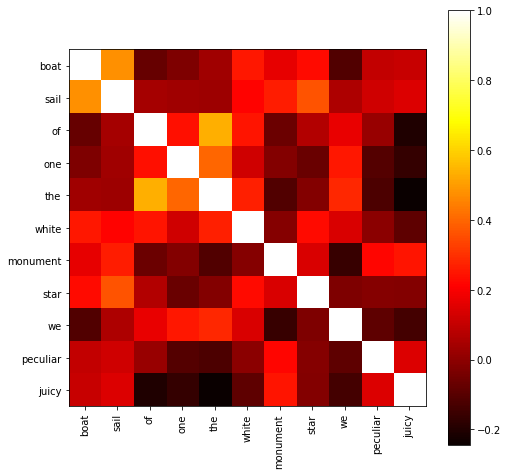

In [110]:
heatmap_similarities(words2)

In [111]:
# primecujemo znacajan uticaj stop reci...

In [116]:
# ostaje jos:
# 1) priprema korpusa za svm 
# - transformiasanje pomocu TdIdf vektorizatora - pozeljno lowercase

# 2) priprema korpusa za cnn
# - priprema matrice embeddinga 
# ! MORAMO PAZITI NA 0 KAO SPECIJALNU VREDNOST ZA PADDING !
# ne zelimo da 0 zbog padding igra ogromnu ulogu (0 treba da je prazna rec...)


